# Install torch

In [ ]:
!pip install torch -q
!pip install torch-geometric -q
!pip install node2vec -q
!pip install optuna -q
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
# Standard library imports
import os
import gzip
import zipfile
import urllib.request
from collections import Counter

# Numerical and scientific computing
import numpy as np

# PyTorch and PyTorch Geometric
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, BatchNorm, global_mean_pool

# Machine Learning and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Graph-specific tools
import networkx as nx
from node2vec import Node2Vec

# Optimization
import optuna

# Experiment tracking
import wandb


import gradio as gr

# Download the `facebook_combined.txt.gz` dataset
## From: https://snap.stanford.edu/data/ego-Facebook.html

In [3]:
# Step 1: Download the Facebook Ego dataset
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
dataset_path = "facebook_combined.txt.gz"

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Facebook dataset downloaded.")



Facebook dataset downloaded.



# Data analysis

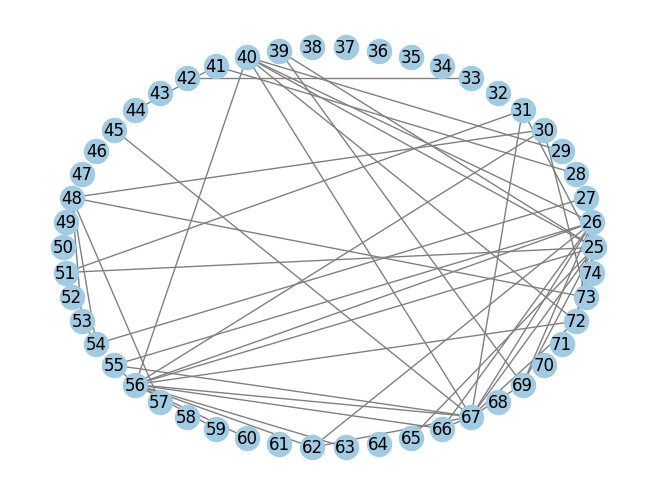

In [4]:
# Load the original graph from the edge list
graph = nx.read_edgelist('facebook_combined.txt.gz', delimiter=' ', create_using=nx.Graph(), nodetype=int)

# Get the first 50 nodes
subgraph = list(graph.nodes())[25:75]

# Create a subgraph with only those 50 nodes
subgraph = graph.subgraph(subgraph)

# Generate the layout for the subgraph
pos = pos = nx.circular_layout(subgraph)
# Draw the subgraph
nx.draw(subgraph, pos, node_color='#A0CBE2', edge_color='#808080', width=1, edge_cmap=plt.cm.Blues, with_labels=True, arrows=False)

# Show the plot
plt.show()

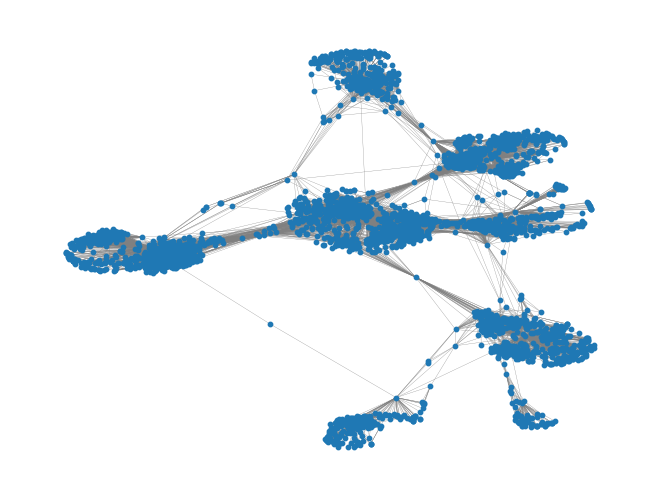

In [ ]:


# Load the original graph from the edge list
graph = nx.read_edgelist('facebook_combined.txt.gz', delimiter=' ', create_using=nx.Graph(), nodetype=int)

# Generate a spring layout for the graph (force-directed)
pos = nx.spring_layout(graph, seed=42)  # Seed for consistent layout

# Draw the graph with smaller nodes and edges
nx.draw(
    graph,
    pos,
    node_size=10,       # Smaller nodes
    edge_color='#808080',
    width=0.2,          # Thinner edges
    edge_cmap=plt.cm.Blues,
    with_labels=False   # No labels
)

# Show the plot
plt.show()


In [6]:
print("The number of unique persons",len(graph.nodes()))

The number of unique persons 4039


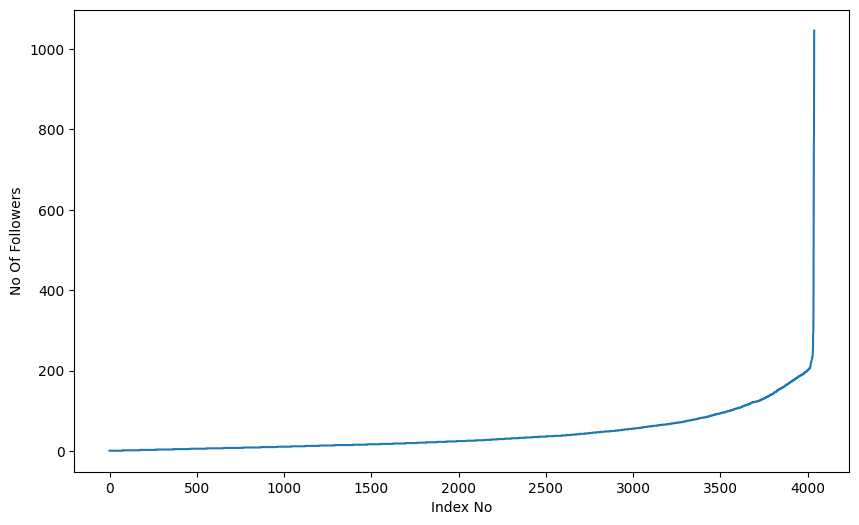

In [7]:
degree_dist = list(dict(graph.degree()).values())
degree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(degree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

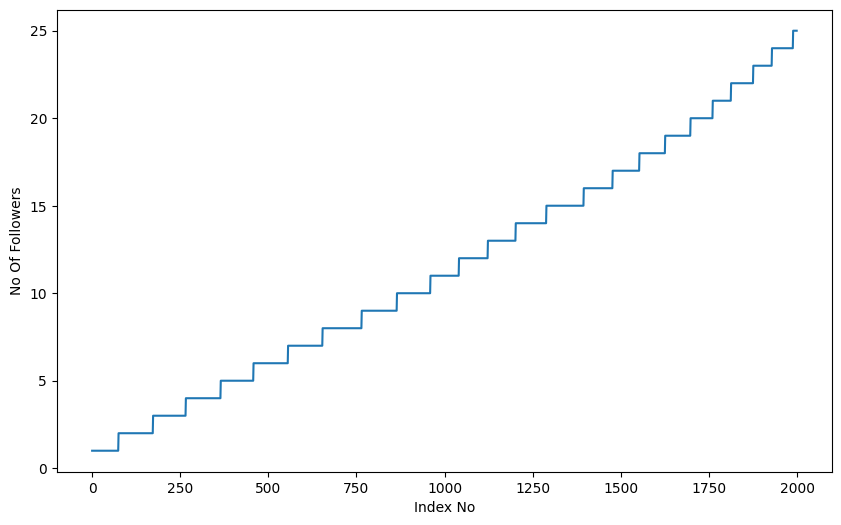

In [8]:
# let's zoom in
degree_dist = list(dict(graph.degree()).values())
degree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(degree_dist[0:2000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

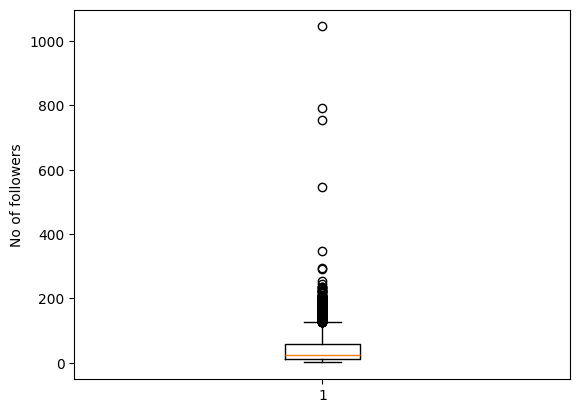

In [9]:
plt.boxplot(degree_dist)
plt.ylabel('No of followers')
plt.show()

In [10]:
# 0 and 90-100 percentile
print(0, "percentile value is", np.percentile(degree_dist,0))
for i in range(0,11):
  print(90+i, "percentile value is", np.percentile(degree_dist,90+i))

0 percentile value is 1.0
90 percentile value is 112.20000000000027
91 percentile value is 119.0
92 percentile value is 124.0
93 percentile value is 132.0
94 percentile value is 141.0
95 percentile value is 153.0999999999999
96 percentile value is 164.0
97 percentile value is 176.0
98 percentile value is 187.0
99 percentile value is 199.6199999999999
100 percentile value is 1045.0


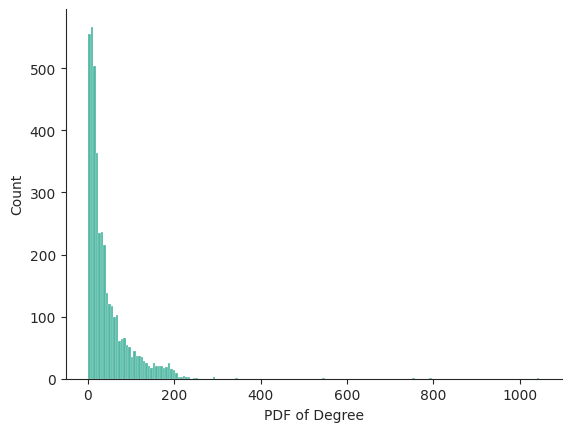

In [11]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
sns.histplot(degree_dist, color='#16A085')
plt.xlabel('PDF of Degree')
sns.despine()
plt.show()

# Data preprocessing

In [ ]:
# Preprocess the data - Create edge list

edges = []
with gzip.open(dataset_path, 'rt') as f:
    for line in f:
        src, dst = map(int, line.strip().split())
        edges.append([src, dst])
edges_list = edges
degrees = Counter([edge[0] for edge in edges_list] + [edge[1] for edge in edges_list])

In [13]:
edges_list = edges
print(len(edges_list))
edges_list = [edge for edge in edges_list if edge[0] != edge[1]]
edges_list = list(set([tuple(sorted(edge)) for edge in edges_list]))
# remove nodes (and their edges) that have a degree below 2
edges_list = [edge for edge in edges_list if degrees[edge[0]] > 1 and degrees[edge[1]] > 1]
print(len(edges_list))
# remove top 1% of nodes with highest degrees
# high_degree_threshold = 0.99
# threshold = np.percentile(list(degrees.values()), 99)
# edges_list = [edge for edge in edges_list if degrees[edge[0]] < threshold and degrees[edge[1]] < threshold]
# print(len(edges_list))

88234
88159


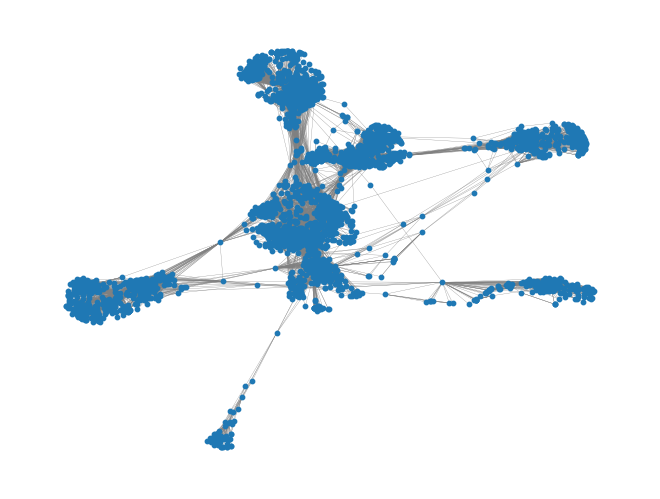

In [ ]:

graph = nx.Graph()
# Load the original graph from the edge list
graph.add_edges_from(edges_list)

# Generate a spring layout for the graph (force-directed)
pos = nx.spring_layout(graph, seed=42)  # Seed for consistent layout

# Draw the graph with smaller nodes and edges
nx.draw(
    graph,
    pos,
    node_size=10,       # Smaller nodes
    edge_color='#808080',
    width=0.2,          # Thinner edges
    edge_cmap=plt.cm.Blues,
    with_labels=False   # No labels
)

# Show the plot
plt.show()

#Baseline

In [ ]:

# Step 1: Build the Graph from the Edge List
def build_graph(edge_list):
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

# Load preprocessed edge list and build the graph
G = build_graph(edges_list)

# Step 2: Split Edges into Train and Test Sets
np.random.seed(42)
edges = np.array(edges_list)
np.random.shuffle(edges)

train_size = int(0.8 * len(edges))  # 80% train, 20% test
train_edges = edges[:train_size]
test_edges = edges[train_size:]

# Non-existent edges to use as negative samples in the test set
all_possible_edges = set(nx.non_edges(G))
negative_samples = np.array(list(all_possible_edges))[:len(test_edges)]

# Step 3: Calculate Jaccard Similarity Scores
def calculate_jaccard_scores(edges, G):
    scores = []
    for src, dst in edges:
        if G.has_node(src) and G.has_node(dst):
            jaccard_score = list(nx.jaccard_coefficient(G, [(src, dst)]))
            if jaccard_score:
                score = jaccard_score[0][2]
            else:
                score = 0
        else:
            score = 0
        scores.append(score)
    return np.array(scores)

# Calculate similarity scores for positive (test edges) and negative samples
positive_scores = calculate_jaccard_scores(test_edges, G)
negative_scores = calculate_jaccard_scores(negative_samples, G)

# Step 4: Evaluate the Baseline Model
# Concatenate scores and create labels for evaluation
all_scores = np.concatenate([positive_scores, negative_scores])
labels = np.concatenate([np.ones(len(positive_scores)), np.zeros(len(negative_scores))])

# Set a threshold to classify edges as "connected" or "not connected"
threshold = 0.5
predictions = (all_scores >= threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(labels, predictions)
auc = roc_auc_score(labels, all_scores)

# Print results
print(f"Baseline Model - Jaccard Similarity")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")


Baseline Model - Jaccard Similarity
Accuracy: 0.6312
AUC: 0.9925


# Gradio interface with baseline

In [ ]:

# Step 1: Build the Graph from the Edge List
def build_graph(edge_list):
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

# Friend recommendation function
def recommend_friend(node, G):
    # Get all possible nodes that are not directly connected to the given node
    potential_friends = list(set(G.nodes()) - set(G.neighbors(node)) - {node})

    if not potential_friends:
        return None, 0

    # Calculate Jaccard Similarity scores for all potential friends
    scores = []
    for potential_friend in potential_friends:
        jaccard_score = list(nx.jaccard_coefficient(G, [(node, potential_friend)]))
        if jaccard_score:
            score = jaccard_score[0][2]
        else:
            score = 0
        scores.append((potential_friend, score))

    # Sort by score in descending order
    scores.sort(key=lambda x: x[1], reverse=True)

    # Return the node with the highest score
    best_match = scores[0] if scores else (None, 0)
    return best_match[0], best_match[1]

# Function to get friends of a given node
def get_friends(node, G):
    return list(G.neighbors(node))

# Gradio function to interactively recommend friends
def gradio_recommend_friend(selected_node):
    if selected_node not in G:
        return (
            "Node not found in the graph. Please enter a valid node number.",
            None,
            None,
            None
        )

    # Recommend a friend for the given node
    recommended_node, score = recommend_friend(selected_node, G)

    # Fetch friends of the selected node
    node_friends = get_friends(selected_node, G)
    node_friends_str = node_friends if node_friends else "No friends found."

    # Fetch friends of the recommended node
    if recommended_node:
        recommended_node_friends = get_friends(recommended_node, G)
        recommended_friends_str = recommended_node_friends if recommended_node_friends else "No friends found."
        common_friends = list(set(node_friends) & set(recommended_node_friends))
        common_friends_str = common_friends if common_friends else "No common friends found."
    else:
        recommended_friends_str = "No recommendation found."
        common_friends_str = ""

    # Return separated outputs
    return (
        f"Recommended friend for node {selected_node}: {recommended_node} with Jaccard score: {score:.4f}" if recommended_node else "No recommendation found.",
        node_friends_str,
        recommended_friends_str,
        common_friends_str
    )

# Build the graph
G = build_graph(edges_list)

# Gradio interface with multiple output components
interface = gr.Interface(
    fn=gradio_recommend_friend,
    inputs=gr.Number(label="Enter Node Number"),
    outputs=[
        gr.Textbox(label="Friend Recommendation"),
        gr.Textbox(label="Friends of Selected Node"),
        gr.Textbox(label="Friends of Recommended Node"),
        gr.Textbox(label="Common Friends")
    ],
    title="Friend Recommendation System",
    description="Enter a node number to get friend recommendations based on Jaccard similarity."
)

# Launch the Gradio app
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0ab7edd58b4692a7cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Adding extra features to the nodes

In [18]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


edges_copy = edges_list
torch_edges = torch.tensor(edges_copy, dtype=torch.long).t().contiguous()
# Number of nodes
num_nodes = torch_edges.max().item() + 1

# Create node features based on node degree
node_degrees = torch.tensor([degrees[node] for node in range(num_nodes)], dtype=torch.float)

# Reshape node features to have them as a feature vector (degree as a single feature)
x = node_degrees.view(-1, 1)

# Calculate the average clustering coefficient
avg_clustering_coeff = nx.average_clustering(graph)

# Add the average clustering coefficient as a feature for every node
avg_clustering_tensor = torch.full((num_nodes, 1), avg_clustering_coeff, dtype=torch.float)

# Append the feature to the existing node features
x = torch.cat([x, avg_clustering_tensor], dim=1)

# Add the diameter as a feature for each node
graph_diameter = 8  # based on the dataset information
diameter_tensor = torch.full((num_nodes, 1), graph_diameter, dtype=torch.float)

# Add the diameter as a feature to each node
x = torch.cat([x, diameter_tensor], dim=1)


# Initialize the Node2Vec model
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=1)

# Fit the model to generate embeddings
model = node2vec.fit(window=5, min_count=1)

# Get embeddings for all nodes as a numpy array
embeddings = []
for node in range(num_nodes):
    key = str(node)  # Ensure consistent string conversion
    if key in model.wv:
        embeddings.append(model.wv[key])
    else:
        #print(f"Node {node} missing from embeddings. Initializing with zeros.")
        embeddings.append(np.zeros(model.vector_size))  # Placeholder
embeddings = np.array(embeddings)

# Convert embeddings to a tensor
embedding_tensor = torch.tensor(embeddings, dtype=torch.float)

# Concatenate the embeddings to the existing feature matrix
x = torch.cat([x, embedding_tensor], dim=1)

# Update the Data object with the new feature matrix
data = Data(x=x, edge_index=torch_edges)

# Save the data object
torch.save(data, 'data_object.pth')

#print(f"Node features based on degree: {data.x[:5]}")

Computing transition probabilities:   0%|          | 0/3964 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [05:44<00:00,  1.72s/it]


#Generating negative edges and splitting up data


In [19]:
# Create labels for friend recommendation
# Positive samples (existing edges)
positive_edges = torch.tensor(edges_copy, dtype=torch.long).t().contiguous()

# Generate negative samples
num_nodes = torch_edges.max().item() + 1
negative_edges = []
while len(negative_edges) < len(positive_edges[0]) // 2:  # Half the size of positive edges
    src = torch.randint(0, num_nodes, (1,)).item()
    dst = torch.randint(0, num_nodes, (1,)).item()
    if src != dst and (src, dst) not in edges_list and (dst, src) not in edges_list:
        negative_edges.append([src, dst])

In [20]:
# Split into train and combined test/validation set
all_edges = torch.cat([positive_edges, torch.tensor(negative_edges, dtype=torch.long).t()], dim=1)
all_labels = torch.cat([torch.ones(positive_edges.size(1)), torch.zeros(len(negative_edges))])  # Labels for edges

train_edges, test_val_edges, train_labels, test_val_labels = train_test_split(
    all_edges.t(), all_labels, test_size=0.2, random_state=42
)

# Create Data object for the training set
train_data = Data(x=x, edge_index=train_edges.t().contiguous(), y=train_labels)

# Split the combined test/validation set into test and validation sets
val_edges, test_edges, val_labels, test_labels = train_test_split(
    test_val_edges, test_val_labels, test_size=0.5, random_state=42
)

# Create Data objects for validation and test sets
val_data = Data(x=x, edge_index=val_edges.t().contiguous(), y=val_labels)
test_data = Data(x=x, edge_index=test_edges.t().contiguous(), y=test_labels)


#Training and testing

In [ ]:

class GCNEdgePrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=3, dropout=0.25):
        super(GCNEdgePrediction, self).__init__()

        # Feature transformation layer
        self.pre_transform = Linear(in_channels, hidden_channels)

        # Define GCN layers with a mix of GCNConv, GATConv, and SAGEConv
        self.layers = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        # First layer: GCNConv
        self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.bns.append(BatchNorm1d(hidden_channels))

        # Intermediate layers: Mix of GCNConv, GATConv, and SAGEConv
        for i in range(1, num_layers - 1):
            if i % 3 == 0:
                self.layers.append(GCNConv(hidden_channels, hidden_channels))
            elif i % 3 == 1:
                self.layers.append(GATConv(hidden_channels, hidden_channels, heads=4, concat=False))
            else:
                self.layers.append(SAGEConv(hidden_channels, hidden_channels))
            self.bns.append(BatchNorm1d(hidden_channels))

        # Last layer: GCNConv
        self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.bns.append(BatchNorm1d(hidden_channels))

        # Fully connected layers
        self.fc1 = Linear(2 * hidden_channels, hidden_channels)
        self.fc2 = Linear(hidden_channels, hidden_channels // 2)
        self.fc3 = Linear(hidden_channels // 2, hidden_channels // 4)
        self.fc4 = Linear(hidden_channels // 4, 1)

        # Dropout rate
        self.dropout = dropout

    def forward(self, x, edge_index, edge_label_index):
        # Pre-transform input features
        x = self.pre_transform(x)

        # GCN Layers with residual connections
        for layer, bn in zip(self.layers, self.bns):
            x_residual = x
            x = layer(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            # Add residual connection if shapes match
            if x.shape == x_residual.shape:
                x += x_residual

        # Edge embeddings: combine features for each pair of nodes
        src, dst = edge_label_index
        edge_embeddings = torch.cat([x[src], x[dst]], dim=1)

        # Fully connected layers for final prediction
        x = F.relu(self.fc1(edge_embeddings))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        edge_scores = self.fc4(x)  # Output score for each edge

        return edge_scores

In [ ]:

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNEdgePrediction(in_channels=data.x.size(1), hidden_channels=128, dropout=0.1097076435322618).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00011840161483188985)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# Training and testing functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index, train_data.edge_index)
    loss = F.binary_cross_entropy_with_logits(out, train_data.y.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    return loss.item()

def test(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_index)
        probs = torch.sigmoid(out).squeeze()
        pred_labels = (probs > 0.5).float()
        acc = accuracy_score(data.y.cpu(), pred_labels.cpu())
        auc = roc_auc_score(data.y.cpu(), probs.cpu())
        return acc, auc

def validate():
    val_acc, val_auc = test(val_data)
    return val_acc, val_auc

# Initialize W&B
wandb.init(project="gcn-edge-prediction")
# Set up W&B configuration and logging
config = wandb.config
config.patience = 150
config.epochs = 2000

patience = config.patience
best_val_auc = 0.0
epochs_without_improvement = 0

for epoch in range(1, config.epochs + 1):
    train_loss = train()
    val_acc, val_auc = validate()

    # Log metrics to W&B
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_accuracy": val_acc,
        "val_auc": val_auc,
    })

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}, best validation AUC: {best_val_auc:.4f}")
        break

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

# Final test evaluation
model.load_state_dict(torch.load('best_model.pth'))
test_acc, test_auc = test(test_data)
print(f"Final Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

# Log final test metrics to W&B
wandb.log({"test_accuracy": test_acc, "test_auc": test_auc})
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 20, Train Loss: 0.5195, Val Accuracy: 0.7023, Val AUC: 0.8030
Epoch 40, Train Loss: 0.4651, Val Accuracy: 0.7517, Val AUC: 0.8253
Epoch 60, Train Loss: 0.4266, Val Accuracy: 0.7608, Val AUC: 0.8280
Epoch 80, Train Loss: 0.4030, Val Accuracy: 0.7706, Val AUC: 0.8328
Epoch 100, Train Loss: 0.3858, Val Accuracy: 0.7722, Val AUC: 0.8304
Epoch 120, Train Loss: 0.3694, Val Accuracy: 0.7705, Val AUC: 0.8284
Epoch 140, Train Loss: 0.3552, Val Accuracy: 0.7682, Val AUC: 0.8266
Epoch 160, Train Loss: 0.3414, Val Accuracy: 0.7638, Val AUC: 0.8226
Epoch 180, Train Loss: 0.3281, Val Accuracy: 0.7627, Val AUC: 0.8211
Epoch 200, Train Loss: 0.3112, Val Accuracy: 0.7550, Val AUC: 0.8123
Epoch 220, Train Loss: 0.2931, Val Accuracy: 0.7595, Val AUC: 0.8161
Early stopping at epoch 226, best validation AUC: 0.8332
Final Test Accuracy: 0.7661, Test AUC: 0.8291


<ipython-input-22-425e3234969b>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test_accuracy,▁
test_auc,▁
train_loss,█▇▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇▇▇███████████████████████████████
val_auc,▁▆▆▆▇▇▇██████████████████▇▇██▇▇▇▇▇▇▇▇▇▇▇
epoch,226
test_accuracy,0.76611
test_auc,0.82905
train_loss,0.28866
val_accuracy,0.75945


#Hyper parameter optimization

In [ ]:

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    hidden_channels = trial.suggest_int('hidden_channels', 64, 256)
    num_layers = trial.suggest_int('num_layers', 1, 16)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Initialize the model and optimizer with trial-suggested parameters
    model = GCNEdgePrediction(
        in_channels=data.x.size(1),
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(50):  # A small number of epochs to save time
        model.train()
        optimizer.zero_grad()
        out = model(train_data.x, train_data.edge_index, train_data.edge_index)
        loss = F.binary_cross_entropy_with_logits(out, train_data.y.float().unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()

    # Validation step
    val_acc, val_auc = test(val_data)  # Assume `test` function works with validation data
    return val_auc  # Return validation AUC as the metric to maximize

# Running Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

# Best trial results
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Best hyperparameters:", trial.params)



[I 2024-12-08 10:46:54,911] A new study created in memory with name: no-name-237337ac-e4f1-4ed3-a17b-eb824a381900
<ipython-input-23-6712f2f46b01>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
[I 2024-12-08 10:46:55,763] Trial 0 finished with value: 0.8331773253978317 and parameters: {'hidden_channels': 78, 'num_layers': 1, 'dropout': 0.19197484337441267, 'learning_rate': 0.005150164119747552, 'batch_size': 32}. Best is trial 0 with value: 0.8331773253978317.
<ipython-input-23-6712f2f46b01>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1

Best trial:
  AUC: 0.8331773767359337
  Best hyperparameters: {'hidden_channels': 195, 'num_layers': 1, 'dropout': 0.2741000810650823, 'learning_rate': 0.0006754968302119923, 'batch_size': 64}


In [24]:
best_trial = study.best_trial
best_params = best_trial.params
model = GCNEdgePrediction(
    in_channels=data.x.size(1),
    hidden_channels=best_params['hidden_channels'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)
# Initialize model and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Initialize W&B
wandb.init(project="gcn-edge-prediction")
# Set up W&B configuration and logging
config = wandb.config
config.patience = 150
config.epochs = 2000

patience = config.patience
best_val_auc = 0.0
epochs_without_improvement = 0

for epoch in range(1, config.epochs + 1):
    train_loss = train()
    val_acc, val_auc = validate()

    # Log metrics to W&B
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_accuracy": val_acc,
        "val_auc": val_auc,
    })

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}, best validation AUC: {best_val_auc:.4f}")
        break

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

# Final test evaluation
model.load_state_dict(torch.load('best_model.pth'))
test_acc, test_auc = test(test_data)
print(f"Final Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

# Log final test metrics to W&B
wandb.log({"test_accuracy": test_acc, "test_auc": test_auc})
wandb.finish()


wandb: Currently logged in as: barnabas-galacz (barnabas-galacz-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg). Use `wandb login --relogin` to force relogin


Epoch 20, Train Loss: 0.4351, Val Accuracy: 0.7821, Val AUC: 0.8487
Epoch 40, Train Loss: 0.3848, Val Accuracy: 0.7709, Val AUC: 0.8296
Epoch 60, Train Loss: 0.3468, Val Accuracy: 0.7722, Val AUC: 0.8339
Epoch 80, Train Loss: 0.2810, Val Accuracy: 0.7612, Val AUC: 0.8209
Epoch 100, Train Loss: 0.2263, Val Accuracy: 0.8056, Val AUC: 0.8701
Epoch 120, Train Loss: 0.1959, Val Accuracy: 0.8520, Val AUC: 0.9180
Epoch 140, Train Loss: 0.1677, Val Accuracy: 0.8591, Val AUC: 0.9244
Epoch 160, Train Loss: 0.1439, Val Accuracy: 0.8673, Val AUC: 0.9314
Epoch 180, Train Loss: 0.1274, Val Accuracy: 0.8769, Val AUC: 0.9375
Epoch 200, Train Loss: 0.1171, Val Accuracy: 0.8848, Val AUC: 0.9429
Epoch 220, Train Loss: 0.1066, Val Accuracy: 0.8969, Val AUC: 0.9549
Epoch 240, Train Loss: 0.0969, Val Accuracy: 0.8946, Val AUC: 0.9534
Epoch 260, Train Loss: 0.0889, Val Accuracy: 0.9132, Val AUC: 0.9627
Epoch 280, Train Loss: 0.0850, Val Accuracy: 0.9144, Val AUC: 0.9665
Epoch 300, Train Loss: 0.0806, Val Acc

<ipython-input-24-eacce12ebf0c>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
test_accuracy,▁
test_auc,▁
train_loss,██▇▆▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇█████▇▇▇██████
val_auc,▁▁▁▁▁▂▄▅▅▅▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,985
test_accuracy,0.94676
test_auc,0.98321
train_loss,0.03483
val_accuracy,0.95107


# Gradio Interface

In [ ]:



# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = torch.load('data_object.pth')
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
model = GCNEdgePrediction(
    in_channels=data.x.size(1),
    hidden_channels=195,
    num_layers=1,
    dropout=0.2741000810650823
).to(device)
# Load model
model.load_state_dict(torch.load('best_model.pth'))

# Move model and data to the selected device
model.to(device)


# Step 1: Generate a larger list of real human names
name_list = [
    "Alice", "Bob", "Charlie", "Diana", "Eve", "Frank", "Grace", "Hannah", "Ivy",
    "Jack", "Kathy", "Liam", "Mia", "Noah", "Olivia", "Paul", "Quinn", "Riley",
    "Sophia", "Tom", "Uma", "Victor", "Willow", "Xander", "Yara", "Zane",
    "Emma", "James", "Lucas", "Ava", "Isabella", "Alexander", "Benjamin",
    "Charlotte", "Daniel", "Elijah", "Ethan", "Henry", "Jacob", "Logan",
    "Madison", "Mason", "Natalie", "Samuel", "Sebastian", "Scarlett", "Zoe",
    "Oliver", "Lily", "Chloe", "Ella", "Emily", "Ryan", "Jason", "Aaron",
    "Nathan", "Matthew", "Sophia", "David", "Sarah", "Anna", "Elizabeth"
]

# Ensure we have enough names for all nodes by repeating names if necessary
num_nodes = data.x.size(0)
while len(name_list) < num_nodes:
    name_list.extend(name_list)  # Duplicate the name list if not enough names

# Shuffle the names randomly
np.random.shuffle(name_list)

# Create a mapping of node index to name
node_names = {i: name_list[i] for i in range(num_nodes)}


# Step 2: Modify the friend recommendation function to use names
def recommend_friend_with_names(node):
    model.eval()

    # Validate node index
    if node < 0 or node >= data.x.size(0):
        return f"Invalid node. Node should be between 0 and {data.x.size(0) - 1}.", None

    # Identify potential friends (nodes not directly connected to the given node)
    existing_edges = set(map(tuple, data.edge_index.t().tolist()))
    potential_friends = [
        i for i in range(data.x.size(0))
        if (node, i) not in existing_edges and (i, node) not in existing_edges and node != i
    ]

    if not potential_friends:
        return f"No potential friends for {node_names[node]}.", None

    # Prepare edges for prediction
    edges_to_predict = torch.tensor(
        [[node, friend] for friend in potential_friends], dtype=torch.long
    ).t().to(device)

    # Predict edge probabilities
    with torch.no_grad():
        preds = model(data.x, data.edge_index, edges_to_predict)
        probs = torch.sigmoid(preds).squeeze().cpu().tolist()

    # Pair potential friends with probabilities
    recommendations = list(zip(potential_friends, probs))

    # Sort recommendations by probability in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Best recommendation
    best_friend, best_score = recommendations[0]
    recommendation_text = (
        f"Recommended friend for {node_names[node]}: {node_names[best_friend]} "
        f"with likelihood {best_score:.4f}"
    )

    # Display top 5 recommendations
    top_5_recommendations = [
        f"{node_names[friend]}: {score:.4f}" for friend, score in recommendations[:5]
    ]

    return recommendation_text, top_5_recommendations

# Step 3: Gradio interface with names
interface = gr.Interface(
    fn=recommend_friend_with_names,
    inputs=gr.Number(label="Enter Node Index"),
    outputs=[
        gr.Textbox(label="Friend Recommendation"),
        gr.Textbox(label="Top 5 Recommendations"),
    ],
    title="GCN Friend Recommendation System with Names",
    description="Enter a node index to get a recommended friend based on the trained GCN model."
)

# Launch Gradio app
interface.launch()


<ipython-input-29-e90f27b3b621>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data_object.pth')
<ipython-input-29-e90f27b3b621>:28: FutureWarning: You

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://482c56f31af8c8e7c5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
